# How Many Cars Will Get Stuck In Traffic?

In this notebook I solve [the following problem](http://fivethirtyeight.com/features/how-many-cars-will-get-stuck-in-traffic/) posed in the riddle section of [FiveThirtyEight](http://fivethirtyeight.com/):

```There is a very long, straight highway with some number of cars (N) placed somewhere along it, randomly. The highway is only one lane, so the cars can’t pass each other. Each car is going in the same direction, and each driver has a distinct positive speed at which she prefers to travel. Each preferred speed is chosen at random. Each driver travels at her preferred speed unless she gets stuck behind a slower car, in which case she remains stuck behind the slower car. On average, how many groups of cars will eventually form? (A group is one or more cars travelling at the same speed.)```

# Closed-Form Solution

One can develop a recursive approach to this problem as follows: 

Define $n_{N}$ to be the expected number of groups to form amongs $N$ cars travelling at random speeds.

When the slowest car, called $s$, is at the back of the pack of cars, it forms its own group. By definition, $n_{N-1}$ groups will be expected to form amongst the $N-1$ cars in front of $s$. Thus a total of $1+n_{N-1}$ groups are expected to form. 

In general, when $s$ is in position $j \in \{i\}_{i=1}^{N}$, the $j-1$ cars behind it will form a single group with $s$. The $N-j$ cars in front of $s$ are expected to form $n_{N-j}$ groups, thus $1+n_{N-j}$ groups are expected to form when $s$ is in position $j$ in traffic.

$s$ occupies each position in traffic with probability $\frac{1}{N}$, thus the expected number of groups to form amongst $N$ cars is:

\begin{equation*}
n_{N} = \frac{1}{N}\sum_{i=0}^{N-1}(1+n_{i}) = \frac{1}{N}(N+\sum_{i=0}^{N-1}n_{i})
\end{equation*}

Trivially, $n_{0}=0$. This can be resummed and simplified:

\begin{equation*}
n_{N} = 1+\frac{1}{N}(1+\frac{1}{N-1}(1+\frac{1}{N-2}(...\frac{1}{1}(1+0)...)))
\end{equation*}

\begin{equation*}
n_{N} = \frac{N!}{N!}+\frac{(N-1)!}{N!}+\frac{(N-2)!}{N!}+...+\frac{0!}{N!}
\end{equation*}

\begin{equation*}
n_{N} = \sum_{k=0}^{N}\frac{k!}{N!}
\end{equation*}

 Thus we arrive at a closed sum relation for the expected number of groups to form amongst $N$ cars.
 
### Interesting Notes 
* It is more efficient to compute $n_{N} = \frac{1}{N}(N+\sum_{i=0}^{N-1}n_{i})$ than it is to use the final sum that we ultimately arrived at.
* $n_{N} \sim \sum_{k=0}^{N}\frac{1}{k} \sim γ+ln(N)+\frac{1}{N}, (N\rightarrow\infty)$  
($γ ≈ 0.5772156649$)

# Coding up the solution

In [48]:
# imports
from __future__ import division

from numba import jit
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
@jit
def num_groups_list(N):
    """ Returns an array of the expected number of groups to form amongst i cars (for i in [0,N]) 
        travelling in the same direction on a single street (no passing is allowed) with random speeds.
        
        N: int
        - The number of cars on the road
        Returns
        -------
        out: ndarray, shape = (N+1,)
        - An array of the expected number of groups for 0, 1, ..., N cars on the road."""
    n = np.zeros(N+1, dtype=float)
    sum_ = 0.
    a = n[0]
    for i in np.arange(1, N+1):
        b = (i + sum_)/i
        n[i] = b
        sum_ += b
    return n           

In [172]:
from scipy.misc import factorial
def num_groups_list2(N):
    """ Returns an array of the expected number of groups to form amongst i cars (for i in [0,N]) 
        travelling in the same direction on a single street (no passing is allowed) with random speeds.
        
        N: int
        - The number of cars on the road
        Returns
        -------
        out: ndarray, shape = (N+1,)
        - An array of the expected number of groups for 0, 1, ..., N cars on the road."""
    facts = factorial(np.arange(N))
    return np.cumsum(facts)/facts

In [177]:
%%timeit
num_groups_list(100000)

1000 loops, best of 3: 604 µs per loop


In [178]:
%%timeit
num_groups_list2(100000)

1000 loops, best of 3: 1.03 ms per loop


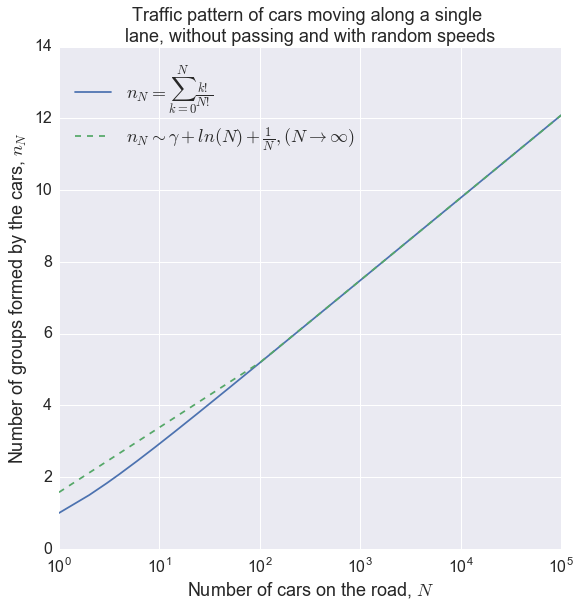

In [194]:
# plot stuff
N = int(1e5)
g = 0.5772156649
fig,ax = plt.subplots(figsize=(9,9)) 
ax.plot(np.arange(N+1),num_groups_list(N), label=r"$n_{N} = \sum_{k=0}^{N}\frac{k!}{N!}$")

x = np.linspace(1,1e5,1000)
ax.plot(x,g+np.log(x)+1/x, ls='--', label=r"$n_{N} \sim \gamma+ln(N)+\frac{1}{N}, (N\rightarrow\infty)$")
ax.tick_params(labelsize=16)
ax.legend(loc='upper left',fontsize=18)
# ax.text(5, 8, r'$n_{N} = \sum_{k=0}^{N}\frac{k!}{N!}$', fontsize=22, 
#         bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})

ax.set_xscale('log')
ax.set_xlabel(r'Number of cars on the road, $N$', fontsize=18)
ax.set_ylabel(r'Number of groups formed by the cars, $n_{N}$', fontsize=18)
ax.set_title('Traffic pattern of cars moving along a single \nlane, without passing and with random speeds', 
             fontsize=18)

# Checking Solution via Monte Carlo Simulation

To simulate this problem, I generate $N$ random speeds, one for each car. I then iterate through the cars, keeping track of the slowest speed I've seen. Each time I see a new slowest speed, a traffic new group has formed.

Repeat a bajillion times for varying $N$ and average the results.

In [133]:
@jit
def traffic_sim(speeds):
    """ Returns an array of simulated number of groups to form amongst N cars 
    travelling in the same direction on a single street (no passing is allowed) 
    with random speeds.

    speeds: ndarray, shape = (num_sim, num_cars)
    - The number of cars on the road
    Returns
    -------
    out: ndarray, shape = (num_sim,)
    - An array of the number of groups found in each simulation."""
    N = speeds.shape[1]
    ensemble = np.zeros(speeds.shape[0])
    for it in range(speeds.shape[0]):
        cnt = 1
        slowest = speeds[it,N-1]
        for car in range(N):#range(N-1,-1,-1):
            speed = speeds[it,car]
            if speed < slowest:
                cnt += 1
                slowest = speed
        ensemble[it] = cnt
    return ensemble

In [163]:
# Running Monte Carlo simulations
sim_results = []
for n in [1, 2, 4]+[int(10**i) for i in range(1,5)]:
    speeds = np.random.rand(int(1e5),n)
    sim_results.append((n,np.mean(traffic_sim(speeds))))
sim_results = np.array(sim_results)

### We find excellent agreement with the simulation and the analytical result:

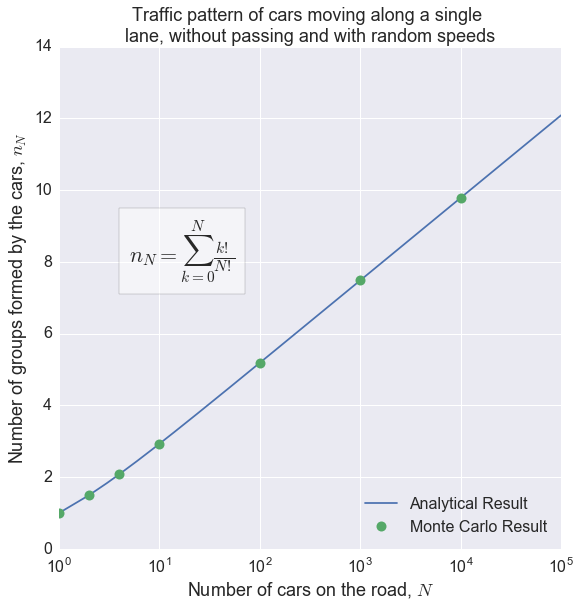

In [190]:
# plot stuff
N = 100000
fig,ax = plt.subplots(figsize=(9,9)) 
ax.plot(np.arange(N+1),num_groups_list(N), label='Analytical Result')
ax.plot(sim_results[:,0],sim_results[:,1], ls='', marker='o', markersize=10, label='Monte Carlo Result')
ax.tick_params(labelsize = 16)
ax.legend(loc='lower right', fontsize=16)
ax.text(5, 8, r'$n_{N} = \sum_{k=0}^{N}\frac{k!}{N!}$', fontsize=22, 
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})

ax.set_xscale('log')
ax.set_xlabel(r'Number of cars on the road, $N$', fontsize=18)
ax.set_ylabel(r'Number of groups formed by the cars, $n_{N}$', fontsize=18)
ax.set_title('Traffic pattern of cars moving along a single \nlane, without passing and with random speeds', 
             fontsize=18)

# Checking accuracy of asymptotic form

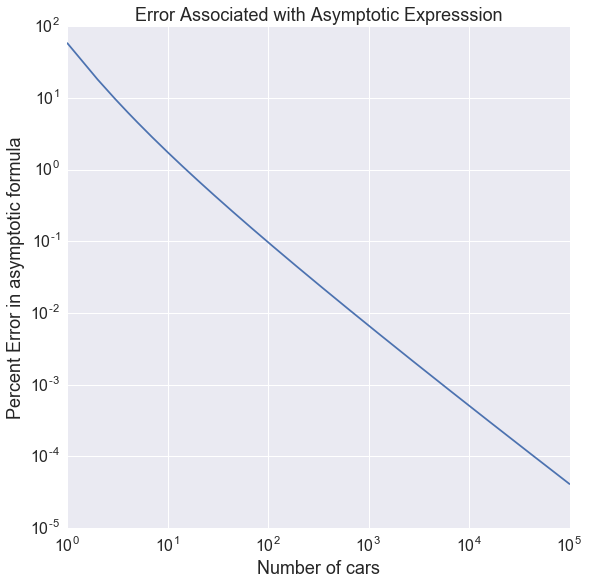

In [203]:
# plot stuff
fig,ax = plt.subplots(figsize=(9,9))
N = int(1e5)
x = np.arange(1,N+1)
asym = g+np.log(x)+1/x
exact = num_groups_list(N)[1:]
ax.tick_params(labelsize = 16)
ax.plot(x,100*(asym-exact)/exact)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of cars', fontsize=18)
ax.set_ylabel('Percent Error in asymptotic formula', fontsize=18)
ax.set_title('Error Associated with Asymptotic Expresssion', 
             fontsize=18)

The asymptotic solution is accurate to within 0.1% of the exact solution by N = 100 cars. It rapidly approaches the exact form as N increases.